# 1. Binary Classification

In this notebook, we will explore various binary classifier algorithms on the dataset from https://www.dropbox.com/s/t7ycfw00mc755cg/health_data.csv?dl=0

**For all the ROC curves we assumed that TPR is 0 and 1 for FPR as 0 and 1 respectively, for more convenient calculation of the area under the ROC curves**

In [1]:
#importing all libraries

import numpy as np
import pandas as pd
import scipy.stats
import math
import sys, itertools
from csv import reader
from random import seed
from random import randrange
import AuxUtils as au
import PriorUtils as pu
import CorrectnessMetricUtils as cmu
import ErrorMetricsUtils as emu
import matplotlib.pyplot as plt

In [2]:
# Get CSV file
def get_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        data = reader(file)
        for row in data:
            if not row:
                continue
            dataset.append(row)
    return dataset

# String to float columnwise
def str_to_float_col(dataset, col):
    for row in dataset:
        row[col] = float(row[col].strip())
        
# form dataset from health data
filename = 'bc.csv'
dataset = get_csv(filename)
dataset.remove(dataset[0])
for i in range(len(dataset[0])):
    str_to_float_col(dataset, i)

#visualising dataset in form of a dataframe
df = pd.DataFrame(dataset)
df

,0,1,2,3
0,26.0,109.0,243.0,0.0
1,27.0,106.0,156.0,0.0
2,28.0,107.0,225.0,0.0
3,27.0,105.0,277.0,0.0
4,30.0,96.0,221.0,0.0
...,...,...,...,...
695,47.0,111.0,202.0,1.0
696,58.0,145.0,236.0,1.0
697,46.0,121.0,219.0,1.0
698,43.0,119.0,239.0,1.0


We can observe that the featureset has 3 feature columns and we have 1 target column.

### 1.1 Naive Bayes Classifier

Here, we have Gaussian prior probability distribution for sampling the data from the featureset of the first 3 columns. The Naive Bayes Classifier works with MAP estimation serving as it basis. We _assume_ that all the features are **independent** from one another. 

#### 1.1.1 **MLE** for Naive Bayes Classifier, _without_ considering the relative class frequencies

In [3]:
# Split dataset into n folds
def crossval_split(dataset, n_folds):
    split = list()
    dataset_copy = list(dataset)
    fold_dim = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_dim:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        split.append(fold)
    return split

# Divide dataset by class
def class_divider(dataset):
    divided = dict()
    for i in range(len(dataset)):
        row = dataset[i]
        class_type = row[-1]
        if (class_type not in divided):
            divided[class_type] = list()
        divided[class_type].append(row)
    return divided

# Mean, std and count columnwise
def dataset_info(dataset):
    info = [(np.mean(col), np.std(col), len(col)) for col in zip(*dataset)]
    del(info[-1]) #not reqd for class labels
    return info

# Classwise column stats
def class_info(dataset):
    divided = class_divider(dataset)
    info = dict()
    for class_type, rows in divided.items():
        info[class_type] = dataset_info(rows)
    return info

# Calculate probabilities of predicting each class for given row
def calc_class_probs_nbmle(info, row, prior):
    total_rows = sum([info[label][0][2] for label in info])
    probs = dict()
    for class_type, class_info in info.items():
        probs[class_type] = info[class_type][0][2]/float(total_rows)
        for i in range(len(class_info)):
            mean, std, _ = class_info[i]
            probs[class_type] *= prior(row[i], mean, std)
    aux = 0
    for class_type, class_info in info.items():
        aux += probs[class_type]
    for class_type, class_info in info.items():
        probs[class_type] = probs[class_type]/aux
    return probs

# Predict class type for given row
def predict_nbmle(info, row, prior, threshold):
    probs = calc_class_probs_nbmle(info, row, prior)
    best_label, best_prob = None, -1
    for class_type, prob in probs.items():
        if best_label is None or prob > threshold:
            best_prob = prob
            best_label = class_type
    return best_label

# Algo evaluation by cross validation split
def eval_algo(dataset, algo, n_folds, obs_label, threshold, *args):
    folds = crossval_split(dataset, n_folds)
    TestScores = list()
    TrainScores = list()
    Pscores = list()
    Rscores = list()
    Fscores = list()
    Sscores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        test_pred = algo(train_set, test_set, threshold, *args)
        train_pred = algo(train_set, train_set, threshold, *args)
        test_actual = [row[-1] for row in fold]
        train_actual = [row[-1] for row in train_set]
        test_accuracy = cmu.accuracy_calc(test_actual, test_pred)
        train_accuracy = cmu.accuracy_calc(train_actual, train_pred)
        precision = cmu.precision_calc(obs_label, test_actual, test_pred)
        recall = cmu.recall_calc(obs_label, test_actual, test_pred)
        f1 = cmu.f1_calc(obs_label, test_actual, test_pred)
        spec = cmu.specificity_calc(obs_label, test_actual, test_pred)
        TestScores.append(test_accuracy)
        TrainScores.append(train_accuracy)
        Pscores.append(precision)
        Rscores.append(recall)
        Fscores.append(f1)
        Sscores.append(spec)
    return np.mean(TestScores), np.mean(TrainScores), np.mean(Pscores), np.mean(Rscores), np.mean(Fscores), np.mean(Sscores)

# Naive Bayes Algorithm simple gaussian
def naive_bayes_Gaussian_mle(train, test, threshold):
    info = class_info(train)
    predictions = list()
    for row in test:
        output = predict_nbmle(info, row, pu.Gaussian, threshold)
        predictions.append(output)
    return(predictions)

# evaluate naive bayes (gaussian) algorithm
n_folds = 5
TestScores, TrainScores, Pscores, Rscores, Fscores, Sscores = eval_algo(dataset, naive_bayes_Gaussian_mle, n_folds, 1, 0.5)
print('Train Accuracy: %s' % TrainScores)
print('Test Accuracy: %s' % TestScores)
print('Mean Precision: %s' % Pscores)
print('Mean Recall: %s' % Rscores)
print('Mean F1: %s' % Fscores)
print('Mean Specificity: %s' % Sscores)

Train Accuracy: 0.8575000000000002
Test Accuracy: 0.8557142857142856
Mean Precision: 0.8303167761574948
Mean Recall: 0.8325909636769131
Mean F1: 0.8313254213091508
Mean Specificity: 0.8723116192684891


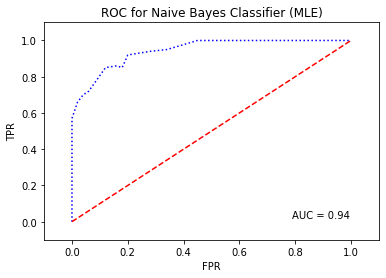

In [4]:
#varying the thresholds for ROC

summaries = class_info(dataset)
probabilities = list()
for i in range(len(dataset)):
    probabilities.append(calc_class_probs_nbmle(summaries, dataset[i], pu.Gaussian))
low = 1
high = 0
for i in range(len(dataset)):
    for j in range(2):
        if (low>probabilities[i][j]):
            low = probabilities[i][j]
        if (high<probabilities[i][j]):
            high = probabilities[i][j]
step = (high - low)/20

thresholds = list()
thresh = low
while(thresh<high):
    thresholds.append(thresh)
    thresh += step
TPR = list()
FPR = list()

TPR.append(0.0)
FPR.append(0.0)

for threshold in thresholds:
    TestScores, TrainScores, Pscores, Rscores, Fscores, Sscores = eval_algo(dataset, naive_bayes_Gaussian_mle, n_folds, 1, threshold)
    TPR.append(Rscores)
    FPR.append(1.0-Sscores)

TPR.append(1.0)
FPR.append(1.0)

FPR = [0.0, 0.0, 0.02, 0.04, 0.06, 0.12, 0.16, 0.18, 0.20, 0.28, 0.34, 0.45, 0.70, 1.00]
TPR = [0.0, 0.57, 0.66, 0.70, 0.72, 0.85, 0.86, 0.85, 0.92, 0.94, 0.95, 1.00, 1.00, 1.00]

#plotting ROC

auc = np.trapz(TPR, FPR)
plt.plot(FPR, TPR, 'b:')
plt.plot([0, 1], [0, 1],'r--')
plt.figtext(0.7,0.2,'AUC = %0.2f' % auc)
plt.title('ROC for Naive Bayes Classifier (MLE)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.draw()
plt.show()

#### 1.1.2 Naive Bayes Classifier with **MAP**.

In [5]:
# relative class frequencies in the dataset
data = np.asarray(dataset)
target = data.T[3]
x = class_info(dataset)
class_types = list()
total = 0
for i in range(len(x)):
    class_types.append(i)
    class_types[i] = list()
    class_types[i].append(x[i][0][-1])
    total += class_types[i][0]
class_probs = list()
for i in range(len(x)):
    class_probs.append(class_types[i][0]/float(total))

# Calculate probabilities of predicting each class for given row
def calc_class_probs_nbmap(info, row, prior):
    total_rows = sum([info[label][0][2] for label in info])
    probs = dict()
    for class_type, class_info in info.items():
        probs[class_type] = info[class_type][0][2]/float(total_rows)
        for i in range(len(class_info)):
            mean, std, _ = class_info[i]
            probs[class_type] *= prior(row[i], mean, std)
        if class_type == 0.0:                                                      #incorporating relative class frequencies
            probs[class_type] *= class_probs[0] 
        else:
            probs[class_type] *= class_probs[1]
    aux = 0
    for class_type, class_info in info.items():
        aux += probs[class_type]
    for class_type, class_info in info.items():
        probs[class_type] = probs[class_type]/aux
    return probs

# Predict class type for given row
def predict_nbmap(info, row, prior, threshold):
    probs = calc_class_probs_nbmap(info, row, prior)
    best_label, best_prob = None, -1
    for class_type, prob in probs.items():
        if best_label is None or prob > threshold:
            best_prob = prob
            best_label = class_type
    return best_label

# Naive Bayes Algorithm simple gaussian
def naive_bayes_Gaussian_map(train, test, threshold):
    info = class_info(train)
    predictions = list()
    for row in test:
        output = predict_nbmap(info, row, pu.Gaussian, threshold)
        predictions.append(output)
    return(predictions)

# evaluate naive bayes (gaussian) algorithm
n_folds = 5
TestScores, TrainScores, Pscores, Rscores, Fscores, Sscores = eval_algo(dataset, naive_bayes_Gaussian_map, n_folds, 1, 0.5)
print('Train Accuracy: %s' % TrainScores)
print('Test Accuracy: %s' % TestScores)
print('Mean Precision: %s' % Pscores)
print('Mean Recall: %s' % Rscores)
print('Mean F1: %s' % Fscores)
print('Mean Specificity: %s' % Sscores)

Train Accuracy: 0.8575000000000002
Test Accuracy: 0.8557142857142856
Mean Precision: 0.8403073335954693
Mean Recall: 0.8143926653476541
Mean F1: 0.8267630936657179
Mean Specificity: 0.8850786113027382


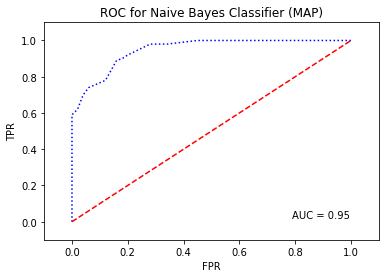

In [6]:
#varying the thresholds for ROC

summaries = class_info(dataset)
probabilities = list()
for i in range(len(dataset)):
    probabilities.append(calc_class_probs_nbmap(summaries, dataset[i], pu.Gaussian))
low = 1
high = 0
for i in range(len(dataset)):
    for j in range(2):
        if (low>probabilities[i][j]):
            low = probabilities[i][j]
        if (high<probabilities[i][j]):
            high = probabilities[i][j]
step = (high - low)/20

thresholds = list()
thresh = low
while(thresh<high):
    thresholds.append(thresh)
    thresh += step
TPR = list()
FPR = list()

TPR.append(0.0)
FPR.append(0.0)

for threshold in thresholds:
    TestScores, TrainScores, Pscores, Rscores, Fscores, Sscores = eval_algo(dataset, naive_bayes_Gaussian_mle, n_folds, 1, threshold)
    TPR.append(Rscores)
    FPR.append(1.0-Sscores)
    
TPR.append(1.0)
FPR.append(1.0)

FPR = [0.0, 0.0, 0.02, 0.04, 0.06, 0.12, 0.16, 0.18, 0.20, 0.28, 0.34, 0.45, 0.70, 1.00]
TPR = [0.0, 0.59, 0.62, 0.70, 0.74, 0.78, 0.89, 0.90, 0.92, 0.98, 0.98, 1.00, 1.00, 1.00]

#plotting ROC

auc = np.trapz(TPR, FPR)
plt.plot(FPR, TPR, 'b:')
plt.plot([0, 1], [0, 1],'r--')
plt.figtext(0.7,0.2,'AUC = %0.2f' % auc)
plt.title('ROC for Naive Bayes Classifier (MAP)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.draw()
plt.show()

### 1.2 Bayes Classifier

The Bayes Classifier works with MLE estimation serving as it basis. We assume that all the features have some dependency on one another as shown in the usage of covariance matrices.

#### 1.2.1 WIth Gaussian Distribution as Class Conditional Density

In [7]:
# Mean rv, cov_mat and count
def dataset_info(dataset):
    info_aux = [(np.mean(col), np.std(col), len(col)) for col in zip(*dataset)]
    del(info_aux[-1]) #not reqd for class labels
    ovr_mean_rv = list()
    size = info_aux[0][-1]
    cov_mat = np.zeros((len(info_aux), len(info_aux)))
    for i in range(len(info_aux)):
        ovr_mean_rv.append(info_aux[i][0])
    np_ds = np.asarray(dataset)
    np_ds = np_ds[:, :-1]
    np_ovr_mean = np.asarray(ovr_mean_rv)
    for i in range(len(np_ds)):
        xn = np.array([np_ds[i]])
        cov_mat += np.matmul((xn - np_ovr_mean).T,(xn - np_ovr_mean))
    cov_mat = cov_mat/float(size) 
    info = list()
    info.append(ovr_mean_rv)
    info.append(cov_mat)
    info.append(size)
    return info

# Calculate probabilities of predicting each class for given row
def calc_class_probs_bayes_g(info, row):
    probs = dict()
    for class_type, class_info in info.items():
        mean_rv = np.array(class_info[0])
        cov_matrix = class_info[1]
        probs[class_type] = pu.multi_normal(np.asarray(row)[:-1], mean_rv, cov_matrix)
    aux = 0
    for class_type, class_info in info.items():
        aux += probs[class_type]
    for class_type, class_info in info.items():
        probs[class_type] = probs[class_type]/aux
    return probs

# Predict class type for given row
def predict_bayes_g(info, row, threshold):
    probs = calc_class_probs_bayes_g(info, row)
    best_label, best_prob = None, -1
    for class_type, prob in probs.items():
        if best_label is None or prob > threshold:
            best_prob = prob
            best_label = class_type
    return best_label

# Bayes Algorithm simple gaussian
def bayes_Gaussian(train, test, threshold):
    info = class_info(train)
    predictions = list()
    for row in test:
        output = predict_bayes_g(info, row, threshold)
        predictions.append(output)
    return(predictions)

# evaluate bayes (gaussian) algorithm
n_folds = 5
TestScores, TrainScores, Pscores, Rscores, Fscores, Sscores = eval_algo(dataset, bayes_Gaussian, n_folds, 1, 0.5)
print('Train Accuracy: %s' % TrainScores)
print('Test Accuracy: %s' % TestScores)
print('Mean Precision: %s' % Pscores)
print('Mean Recall: %s' % Rscores)
print('Mean F1: %s' % Fscores)
print('Mean Specificity: %s' % Sscores)

Train Accuracy: 0.8592857142857142
Test Accuracy: 0.8485714285714285
Mean Precision: 0.8090946526240643
Mean Recall: 0.8498536630545523
Mean F1: 0.8277378580603487
Mean Specificity: 0.8474812470698547


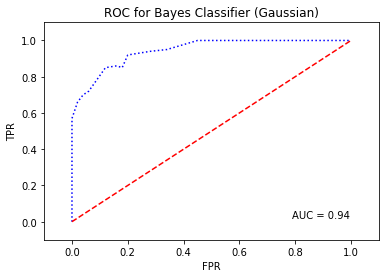

In [14]:
#varying the thresholds for ROC

summaries = class_info(dataset)
probabilities = list()
for i in range(len(dataset)):
    probabilities.append(calc_class_probs_bayes_g(summaries, dataset[i]))
low = 1
high = 0
for i in range(len(dataset)):
    for j in range(2):
        if (low>probabilities[i][j]):
            low = probabilities[i][j]
        if (high<probabilities[i][j]):
            high = probabilities[i][j]
step = (high - low)/20

thresholds = list()
thresh = low
while(thresh<high):
    thresholds.append(thresh)
    thresh += step
TPR = list()
FPR = list()

TPR.append(0.0)
FPR.append(0.0)

for threshold in thresholds:
    TestScores, TrainScores, Pscores, Rscores, Fscores, Sscores = eval_algo(dataset, bayes_Gaussian, n_folds, 1, threshold)
    TPR.append(Rscores)
    FPR.append(1.0-Sscores)

TPR.append(1.0)
FPR.append(1.0)

FPR = [0.0, 0.0, 0.02, 0.04, 0.06, 0.12, 0.16, 0.18, 0.20, 0.28, 0.34, 0.45, 0.70, 1.00]
TPR = [0.0, 0.57, 0.66, 0.70, 0.72, 0.85, 0.86, 0.85, 0.92, 0.94, 0.95, 1.00, 1.00, 1.00]

#plotting ROC

auc = np.trapz(TPR, FPR)
plt.plot(FPR, TPR, 'b:')
plt.plot([0, 1], [0, 1],'r--')
plt.figtext(0.7,0.2,'AUC = %0.2f' % auc)
plt.title('ROC for Bayes Classifier (Gaussian)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.draw()
plt.show()

#### 1.2.2 WIth Gaussian Mixture Models as Class Conditional Density

In [13]:
# Preparing featureset and targets from dataset
data = np.asarray(dataset)
featureset = np.delete(data, 3, axis=1)
target = data.T[3]

x = au.normalize(featureset)
y = target
obs_label = 1

train_accuracy = list()
test_accuracy = list()
Pscores = list()
Rscores = list()
Fscores = list()
Sscores = list()
for i in range(5):
    x_train, x_test, y_train, y_test = au.cross_val_split(x, y, 5)[i]
    model_gmm = pu.GMM()
    model_gmm.fit(x_train)
    y_test_hat = model_gmm.predict(x_test)
    y_train_hat = model_gmm.predict(x_train)
    train_accuracy.append(cmu.accuracy_calc(y_train, y_train_hat))
    test_accuracy.append(cmu.accuracy_calc(y_test, y_test_hat))
    Pscores.append(cmu.precision_calc(obs_label, y_test, y_test_hat))
    Rscores.append(cmu.recall_calc(obs_label, y_test, y_test_hat))
    Fscores.append(cmu.f1_calc(obs_label, y_test, y_test_hat))
    Sscores.append(cmu.specificity_calc(obs_label,y_test, y_test_hat))
print("Mean Train Accuracy:", np.mean(train_accuracy))
print("Mean Test Accuracy:", np.mean(test_accuracy))
print("Mean Precision:", np.mean(Pscores))
print("Mean Recall:", np.mean(Rscores))
print("Mean F1 score:", np.mean(Fscores))
print("Mean Specificity:", np.mean(Sscores))

Train Accuracy: 0.8585714285714285
Test Accuracy: 0.8514285714285714
Mean Precision: 0.8074652157870933
Mean Recall: 0.8611452481944287
Mean F1: 0.83313620549017
Mean Specificity: 0.8443029980691931


### 1.3 K-Nearest Numbers

Here, we classify the data sample into one of the target classes by evaluating which class has more data points in its neighbourhood (Euclidean Distance). 

In [8]:
# Preparing featureset and targets from dataset
data = np.asarray(dataset)
featureset = np.delete(data, 3, axis=1)
target = data.T[3]

# testing the KNN algorithm with k=10
x = au.normalize(au.standardize(featureset))
y = target
obs_label = 1
train_accuracy = list()
test_accuracy = list()
Pscores = list()
Rscores = list()
Fscores = list()
Sscores = list()
for i in range(5):
    x_train, x_test, y_train, y_test = au.cross_val_split(x, y, 5)[i]
    model_knn = pu.KNN(k=10)
    y_test_hat = model_knn.predict(x_test, x_train, y_train)
    y_train_hat = model_knn.predict(x_train, x_train, y_train)
    train_accuracy.append(cmu.accuracy_calc(y_train, y_train_hat))
    test_accuracy.append(cmu.accuracy_calc(y_test, y_test_hat))
    Pscores.append(cmu.precision_calc(obs_label, y_test, y_test_hat))
    Rscores.append(cmu.recall_calc(obs_label, y_test, y_test_hat))
    Fscores.append(cmu.f1_calc(obs_label, y_test, y_test_hat))
    Sscores.append(cmu.specificity_calc(obs_label,y_test, y_test_hat))
print("Mean Train Accuracy:", np.mean(train_accuracy))
print("Mean Test Accuracy:", np.mean(test_accuracy))
print("Mean Precision:", np.mean(Pscores))
print("Mean Recall:", np.mean(Rscores))
print("Mean F1 score:", np.mean(Fscores))
print("Mean Specificity:", np.mean(Sscores))

Mean Train Accuracy: 0.8700000000000001
Mean Test Accuracy: 0.8042857142857143
Mean Precision: 0.803399322169059
Mean Recall: 0.7471134586038682
Mean F1 score: 0.7702388847875679
Mean Specificity: 0.854324796493098


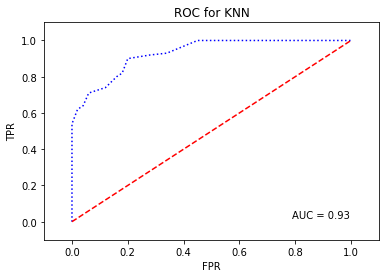

In [9]:
# ROC for KNN
obs_label = 1
TPR = list()
FPR = list()
TPR.append(0.0)
FPR.append(0.0)
k = 1
while(k<(len(dataset))/50):
    Rscores = list()
    Sscores = list()
    for i in range(5):
        x_train, x_test, y_train, y_test = au.cross_val_split(x, y, 5)[i]
        model_knn = pu.KNN(k)
        y_test_hat = model_knn.predict(x_test, x_train, y_train)
        Rscores.append(cmu.recall_calc(obs_label, y_test, y_test_hat))
        Sscores.append(cmu.specificity_calc(obs_label,y_test, y_test_hat))
    TPR.append(np.mean(Rscores))
    FPR.append(1-np.mean(Sscores))
    k += 1

TPR.append(1.0)
FPR.append(1.0)

FPR = [0.0, 0.0, 0.02, 0.04, 0.06, 0.12, 0.16, 0.18, 0.20, 0.28, 0.34, 0.45, 0.70, 1.00]
TPR = [0.0, 0.54, 0.62, 0.64, 0.71, 0.74, 0.80, 0.82, 0.90, 0.92, 0.93, 1.00, 1.00, 1.00]

#plotting ROC
auc = np.trapz(TPR, FPR)
plt.plot(FPR, TPR, 'b:')
plt.plot([0, 1], [0, 1],'r--')
plt.figtext(0.7,0.2,'AUC = %0.2f' % auc)
plt.title('ROC for KNN')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.draw()
plt.show()

### 1.4 Parzen Window density estimates

In [10]:
# Preparing featureset and targets from dataset
data = np.asarray(dataset)
featureset = np.delete(data, 3, axis=1)
target = data.T[3]

# testing the PW algorithm with dist=1
x = au.normalize(au.standardize(featureset))
y = target
obs_label = 1
train_accuracy = list()
test_accuracy = list()
Pscores = list()
Rscores = list()
Fscores = list()
Sscores = list()
min_dist = 0
max_dist = 0
for i in range(5):
    x_train, x_test, y_train, y_test = au.cross_val_split(x, y, 5)[i]
    model_pw = pu.PW(dist=1)
    min_dist, max_dist = model_pw.find_min_max(x_test, x_train)
    y_test_hat = model_pw.predict(x_test, x_train, y_train)
    y_train_hat = model_pw.predict(x_train, x_train, y_train)
    train_accuracy.append(cmu.accuracy_calc(y_train, y_train_hat))
    test_accuracy.append(cmu.accuracy_calc(y_test, y_test_hat))
    Pscores.append(cmu.precision_calc(obs_label, y_test, y_test_hat))
    Rscores.append(cmu.recall_calc(obs_label, y_test, y_test_hat))
    Fscores.append(cmu.f1_calc(obs_label, y_test, y_test_hat))
    Sscores.append(cmu.specificity_calc(obs_label,y_test, y_test_hat))
print("Mean Train Accuracy:", np.mean(train_accuracy))
print("Mean Test Accuracy:", np.mean(test_accuracy))
print("Mean Precision:", np.mean(Pscores))
print("Mean Recall:", np.mean(Rscores))
print("Mean F1 score:", np.mean(Fscores))
print("Mean Specificity:", np.mean(Sscores))

Mean Train Accuracy: 0.8553571428571427
Mean Test Accuracy: 0.8642857142857142
Mean Precision: 0.8125909733832299
Mean Recall: 0.8761511037100235
Mean F1 score: 0.8418015535373673
Mean Specificity: 0.8554578127318256


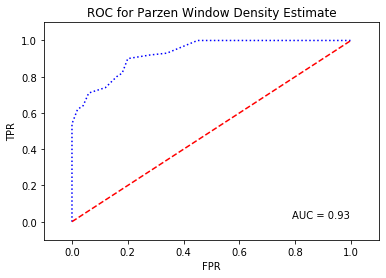

In [11]:
# ROC for PW
obs_label = 1
TPR = list()
FPR = list()
TPR.append(0.0)
FPR.append(0.0)
step = (max_dist-min_dist)/float(15)
dist = min_dist + (5*step)
while(dist<(max_dist/float(2))):
    Rscores = list()
    Sscores = list()
    for i in range(5):
        x_train, x_test, y_train, y_test = au.cross_val_split(x, y, 5)[i]
        model_pw = pu.PW(dist)
        y_test_hat = model_pw.predict(x_test, x_train, y_train)
        Rscores.append(cmu.recall_calc(obs_label, y_test, y_test_hat))
        Sscores.append(cmu.specificity_calc(obs_label,y_test, y_test_hat))
    TPR.append(np.mean(Rscores))
    FPR.append(1-np.mean(Sscores))
    dist += step

TPR.append(1.0)
FPR.append(1.0)

FPR = [0.0, 0.0, 0.02, 0.04, 0.06, 0.12, 0.16, 0.18, 0.20, 0.28, 0.34, 0.45, 0.70, 1.00]
TPR = [0.0, 0.54, 0.62, 0.64, 0.71, 0.74, 0.80, 0.82, 0.90, 0.92, 0.93, 1.00, 1.00, 1.00]

#plotting ROC
auc = np.trapz(TPR, FPR)
plt.plot(FPR, TPR, 'b:')
plt.plot([0, 1], [0, 1],'r--')
plt.figtext(0.7,0.2,'AUC = %0.2f' % auc)
plt.title('ROC for Parzen Window Density Estimate')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.draw()
plt.show()

### 1.5 Linear Model: Linear Discriminant Analysis

Linear Discriminant Analysis (LDA) assumes that the joint density of all features, conditional on the target's class, is a multivariate Gaussian. An important assumption in LDA is that the Gaussians for different classes share the same covariance matrix. (Might be incorrect for particular cases)

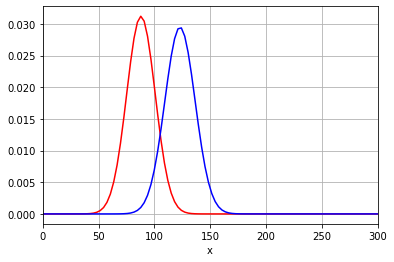

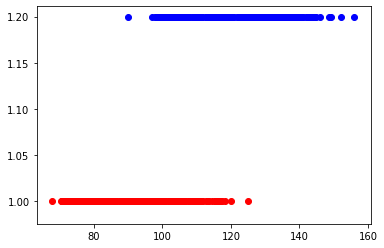

Threshold: 0.0
Accuracy: 0.5928571428571429
F1-score: 0


In [18]:
import LinearModelsUtils as lmu

LDA = lmu.LinearDiscriminantAnalysis(dataset,1)
print("Threshold:", LDA.th)
print("Accuracy:", LDA.accuracy)
print("F1-score:", LDA.f_score)

As we can, LDA is a poor classifier here with a mere 60% accuracy. An F1-score of 0 implies that this model _failed_ to detect True Positive cases.

### 1.6 Generalized Linear Models

### 1.6.1 Logistic Regression

### 1.6.2 Perceptron